#### Задание 

Датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv))

* Использовать 10-fold кросс-валидацию для оценки качества моделей
* Построить случайный лес, вывести важность признаков
* Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
* Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
* Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from jupyterthemes import jtplot
from sklearn.metrics import auc, roc_curve, roc_auc_score
%matplotlib inline
jtplot.style()

from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn import datasets, linear_model

In [2]:
data = pd.read_csv('house_prices_dz_ens/train.csv')

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
data['target'] = data.SalePrice.apply(lambda num : round(num / data.SalePrice.min()))
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,target
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,6
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,5
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,6
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,4
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,7


In [5]:
data.target.value_counts()
#data[data.SalePrice < 110900].SalePrice.value_counts(bins=10)
#data.SalePrice.min()

4     401
5     300
3     210
6     170
7     120
8      72
2      64
9      46
11     22
10     21
12     10
13      7
1       6
14      3
16      2
18      2
21      1
15      1
17      1
22      1
Name: target, dtype: int64

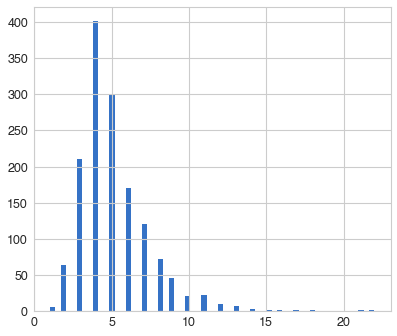

In [9]:
data.target.hist(bins=60)

* SalePrice - цена продажи объекта в долларах. Это целевая переменная, которую вы пытаетесь предсказать.
* MSSubClass : класс здания
* MSZoning : Общая классификация зонирования
* LotFrontage : Линейные ноги улицы, соединенной с участком
* LotArea : Размер лота в квадратных футах.
* Street : Тип подъездной дороги
* Alley : Тип подъезда к аллее
* LotShape : Общая форма собственности
* LandContour : Плоскостность собственности
* Utilities : Тип имеющихся утилит
* LotConfig : Конфигурация лота
* LandSlope : склон собственности
* Neighborhood : Физические места в черте города Эймс.
* Condition 1 : Близость к главной дороге или железной дороге
* Condition 2 : Близость к главной дороге или железной дороге (если есть второй)
* BldgType : Тип жилья
* HouseStyle : Стиль жилища
* OverallQual : Общий материал и качество отделки
* OverallCond : Общая оценка состояния
* YearBuilt: Дата постройки.
* YearRemodAdd : Дата реконструкции
* RoofStyle : Тип крыши
* RoofMatl : Материал крыши
* Exterior1st : Наружное покрытие дома.
* Exterior2nd : Наружное покрытие дома (если используется более одного материала).
* MasVnrType : Тип облицовки кладки
* MasVnrArea : Площадь облицовки кладки в квадратных футах
* ExterQual : Качество наружных материалов
* ExterCond : Текущее состояние материала снаружи.
* Foundation : Тип фундамента
* BsmtQual : Высота подвала
* BsmtCond : Общее состояние подвала.
* BsmtExposure : Подвальные стены на уровне сада или выхода
* BsmtFinType1 : Качество готовой площади подвала
* BsmtFinSF1 : Готовые квадратные футы типа 1
* BsmtFinType2 : Качество второй законченной области (если есть)
* BsmtFinSF2 : Готовые квадратные ножки типа 2
* BsmtUnfSF : Незавершенные квадратные футы подвала
* TotalBsmtSF : Общая площадь подвала в квадратных футах
* Heating : Тип отопления
* HeatingQC : Качество и состояние отопления
* CentralAir : Центральное кондиционирование
* Electrical : электрическая система
* 1stFlrSF : квадратные футы на первом этаже
* 2ndFlrSF : квадратные футы второго этажа
* LowQualFinSF : квадратные футы с отделкой низкого качества (все этажи)
* GrLivArea : квадратные футы жилой площади надземного уровня
* BsmtFullBath : Полные ванные комнаты в подвале
* BsmtHalfBath : полуподвальные ванные комнаты
* FullBath : Полные ванные комнаты выше уровня
* HalfBath : Полуванны выше уровня
* Bedroom : Количество спален над цокольным этажом
* Kitchen : Количество кухонь
* KitchenQual : Качество кухни
* TotRmsAbvGrd : Общее количество комнат выше уровня (без ванных комнат)
* Functional : Рейтинг функциональности дома
* Fireplaces : Количество каминов
* FireplaceQu : качество камина
* GarageType : расположение гаража
* GarageYrBlt : Год постройки гаража
* GarageFinish : Внутренняя отделка гаража.
* GarageCars : Размер гаража по вместимости машины
* GarageArea : Размер гаража в квадратных футах.
* GarageQual : качество гаража
* GarageCond : Состояние гаража
* PavedDrive : подъездная дорога с твердым покрытием
* WoodDeckSF : Площадь деревянного настила в квадратных футах
* OpenPorchSF : Площадь открытой веранды в квадратных футах
* EnclosedPorch : Площадь крыльца в квадратных футах.
* 3SsnPorch : Площадь крыльца на три сезона в квадратных футах
* ScreenPorch : Площадь крыльца экрана в квадратных футах
* PoolArea : Площадь бассейна в квадратных футах.
* PoolQC : качество бассейна
* Fence : качество забора
* MiscFeature : прочие функции, не относящиеся к другим категориям
* MiscVal :  Значение дополнительных функций
* MoSold : месяц продажи
* YrSold : Год продажи
* SaleType : Тип продажи
* SaleCondition : Состояние продажи

In [14]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'SalePrice', 'target'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = data_train[cat_feat].nunique()
print(cat_nunique)


MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         1
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        6
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          7
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           5
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64


In [107]:
# Создаем дамми-переменные для категорий
dummy_data = pd.get_dummies(data[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_data))

dummy_data = dummy_data[dummy_cols]

# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
#data999 = pd.concat([data[num_feat].fillna(-999), dummy_data], axis=1)
data999 = pd.concat([data[num_feat].fillna(value=data[num_feat].mean()), dummy_data], axis=1)

In [156]:
# Применим KFold для разделения данных и сравним разные модели на лучшем наборе параметров, полученном ниже
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from catboost import CatBoostClassifier
from statistics import mean
from warnings import filterwarnings 

filterwarnings('ignore')

clf_lg = make_pipeline(StandardScaler(), LogisticRegression())
clf_rf = RandomForestClassifier()
clf_tree = DecisionTreeClassifier()
clf_cat = CatBoostClassifier()
clf_bag = BaggingClassifier()

clf_stack = StackingClassifier(
    [
        ('lr', make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))),
        ('dt', DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)),
        ('rf', RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1))
    ], BaggingClassifier(n_estimators=10, base_estimator=DecisionTreeClassifier(), n_jobs=-1))

#n_samples = data999.shape[0]
#cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
#scores = cross_val_score(clf_lg, data999, data['target'], cv=cv)

from sklearn.model_selection import KFold

model = [clf_lg, clf_rf, clf_tree, clf_cat, clf_bag, clf_stack]
list_sc = []

X = data999[best_param]
y = data['target']

kf = KFold(n_splits=10)

for m in model:
    
    for train, test in kf.split(X):

        X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y[train], y[test]
    
        m.fit(X_train, y_train)
        sc = m.score(X_test, y_test)
        
        list_sc.append(sc)
    
    classifiers[type(m).__name__] = mean(list_sc)
    list_sc = []
    
classifiers

Learning rate set to 0.080236
0:	learn: 2.7583652	total: 16.3ms	remaining: 16.3s
1:	learn: 2.5595996	total: 31.1ms	remaining: 15.5s
2:	learn: 2.4366359	total: 41.5ms	remaining: 13.8s
3:	learn: 2.3144648	total: 52.7ms	remaining: 13.1s
4:	learn: 2.2047819	total: 63.9ms	remaining: 12.7s
5:	learn: 2.1181784	total: 77.6ms	remaining: 12.8s
6:	learn: 2.0418374	total: 91.5ms	remaining: 13s
7:	learn: 1.9681214	total: 106ms	remaining: 13.1s
8:	learn: 1.9110985	total: 120ms	remaining: 13.2s
9:	learn: 1.8499637	total: 132ms	remaining: 13.1s
10:	learn: 1.7989201	total: 144ms	remaining: 12.9s
11:	learn: 1.7496862	total: 157ms	remaining: 12.9s
12:	learn: 1.7023361	total: 172ms	remaining: 13s
13:	learn: 1.6645678	total: 187ms	remaining: 13.2s
14:	learn: 1.6264626	total: 199ms	remaining: 13s
15:	learn: 1.5906642	total: 211ms	remaining: 13s
16:	learn: 1.5552867	total: 223ms	remaining: 12.9s
17:	learn: 1.5257120	total: 235ms	remaining: 12.8s
18:	learn: 1.4922342	total: 247ms	remaining: 12.8s
19:	learn: 1

163:	learn: 0.7591585	total: 2.28s	remaining: 11.6s
164:	learn: 0.7579040	total: 2.29s	remaining: 11.6s
165:	learn: 0.7565932	total: 2.3s	remaining: 11.6s
166:	learn: 0.7543222	total: 2.32s	remaining: 11.6s
167:	learn: 0.7520306	total: 2.33s	remaining: 11.5s
168:	learn: 0.7503863	total: 2.35s	remaining: 11.5s
169:	learn: 0.7488783	total: 2.36s	remaining: 11.5s
170:	learn: 0.7465536	total: 2.37s	remaining: 11.5s
171:	learn: 0.7450981	total: 2.39s	remaining: 11.5s
172:	learn: 0.7438349	total: 2.4s	remaining: 11.5s
173:	learn: 0.7421979	total: 2.42s	remaining: 11.5s
174:	learn: 0.7405609	total: 2.43s	remaining: 11.5s
175:	learn: 0.7396166	total: 2.45s	remaining: 11.5s
176:	learn: 0.7379989	total: 2.46s	remaining: 11.5s
177:	learn: 0.7369816	total: 2.48s	remaining: 11.4s
178:	learn: 0.7360063	total: 2.49s	remaining: 11.4s
179:	learn: 0.7343835	total: 2.5s	remaining: 11.4s
180:	learn: 0.7327300	total: 2.52s	remaining: 11.4s
181:	learn: 0.7310004	total: 2.53s	remaining: 11.4s
182:	learn: 0.7

336:	learn: 0.5570461	total: 4.53s	remaining: 8.91s
337:	learn: 0.5558201	total: 4.55s	remaining: 8.9s
338:	learn: 0.5548503	total: 4.56s	remaining: 8.89s
339:	learn: 0.5538152	total: 4.57s	remaining: 8.88s
340:	learn: 0.5526238	total: 4.58s	remaining: 8.86s
341:	learn: 0.5516946	total: 4.6s	remaining: 8.85s
342:	learn: 0.5509331	total: 4.61s	remaining: 8.83s
343:	learn: 0.5501166	total: 4.62s	remaining: 8.81s
344:	learn: 0.5489557	total: 4.63s	remaining: 8.8s
345:	learn: 0.5477131	total: 4.65s	remaining: 8.78s
346:	learn: 0.5471620	total: 4.66s	remaining: 8.77s
347:	learn: 0.5462849	total: 4.68s	remaining: 8.77s
348:	learn: 0.5451166	total: 4.69s	remaining: 8.75s
349:	learn: 0.5445777	total: 4.7s	remaining: 8.73s
350:	learn: 0.5438009	total: 4.71s	remaining: 8.72s
351:	learn: 0.5428176	total: 4.73s	remaining: 8.7s
352:	learn: 0.5420337	total: 4.74s	remaining: 8.68s
353:	learn: 0.5413273	total: 4.75s	remaining: 8.67s
354:	learn: 0.5400025	total: 4.76s	remaining: 8.65s
355:	learn: 0.539

502:	learn: 0.4341819	total: 6.56s	remaining: 6.48s
503:	learn: 0.4337664	total: 6.57s	remaining: 6.47s
504:	learn: 0.4331543	total: 6.58s	remaining: 6.45s
505:	learn: 0.4326329	total: 6.59s	remaining: 6.44s
506:	learn: 0.4323251	total: 6.61s	remaining: 6.42s
507:	learn: 0.4319000	total: 6.62s	remaining: 6.41s
508:	learn: 0.4315022	total: 6.63s	remaining: 6.39s
509:	learn: 0.4310618	total: 6.64s	remaining: 6.38s
510:	learn: 0.4305388	total: 6.65s	remaining: 6.37s
511:	learn: 0.4298884	total: 6.66s	remaining: 6.35s
512:	learn: 0.4292335	total: 6.68s	remaining: 6.34s
513:	learn: 0.4287152	total: 6.69s	remaining: 6.33s
514:	learn: 0.4283238	total: 6.7s	remaining: 6.31s
515:	learn: 0.4279698	total: 6.71s	remaining: 6.3s
516:	learn: 0.4272129	total: 6.73s	remaining: 6.28s
517:	learn: 0.4268038	total: 6.74s	remaining: 6.27s
518:	learn: 0.4264997	total: 6.75s	remaining: 6.26s
519:	learn: 0.4262501	total: 6.77s	remaining: 6.25s
520:	learn: 0.4258033	total: 6.78s	remaining: 6.24s
521:	learn: 0.

661:	learn: 0.3607196	total: 8.61s	remaining: 4.39s
662:	learn: 0.3603038	total: 8.62s	remaining: 4.38s
663:	learn: 0.3600818	total: 8.63s	remaining: 4.37s
664:	learn: 0.3596943	total: 8.64s	remaining: 4.35s
665:	learn: 0.3594025	total: 8.65s	remaining: 4.34s
666:	learn: 0.3589920	total: 8.67s	remaining: 4.33s
667:	learn: 0.3585790	total: 8.68s	remaining: 4.31s
668:	learn: 0.3580370	total: 8.69s	remaining: 4.3s
669:	learn: 0.3574757	total: 8.7s	remaining: 4.29s
670:	learn: 0.3569024	total: 8.72s	remaining: 4.27s
671:	learn: 0.3563279	total: 8.73s	remaining: 4.26s
672:	learn: 0.3559518	total: 8.74s	remaining: 4.25s
673:	learn: 0.3556141	total: 8.75s	remaining: 4.23s
674:	learn: 0.3549530	total: 8.77s	remaining: 4.22s
675:	learn: 0.3546794	total: 8.78s	remaining: 4.21s
676:	learn: 0.3542277	total: 8.79s	remaining: 4.19s
677:	learn: 0.3537193	total: 8.8s	remaining: 4.18s
678:	learn: 0.3531615	total: 8.81s	remaining: 4.17s
679:	learn: 0.3529223	total: 8.82s	remaining: 4.15s
680:	learn: 0.3

826:	learn: 0.3019223	total: 10.7s	remaining: 2.23s
827:	learn: 0.3016536	total: 10.7s	remaining: 2.22s
828:	learn: 0.3012874	total: 10.7s	remaining: 2.21s
829:	learn: 0.3009420	total: 10.7s	remaining: 2.19s
830:	learn: 0.3007463	total: 10.7s	remaining: 2.18s
831:	learn: 0.3004914	total: 10.7s	remaining: 2.17s
832:	learn: 0.3002119	total: 10.7s	remaining: 2.15s
833:	learn: 0.2998533	total: 10.8s	remaining: 2.14s
834:	learn: 0.2995049	total: 10.8s	remaining: 2.13s
835:	learn: 0.2993220	total: 10.8s	remaining: 2.12s
836:	learn: 0.2990276	total: 10.8s	remaining: 2.11s
837:	learn: 0.2987537	total: 10.8s	remaining: 2.09s
838:	learn: 0.2985022	total: 10.8s	remaining: 2.08s
839:	learn: 0.2980540	total: 10.9s	remaining: 2.07s
840:	learn: 0.2978212	total: 10.9s	remaining: 2.05s
841:	learn: 0.2975866	total: 10.9s	remaining: 2.04s
842:	learn: 0.2973728	total: 10.9s	remaining: 2.03s
843:	learn: 0.2970439	total: 10.9s	remaining: 2.01s
844:	learn: 0.2968850	total: 10.9s	remaining: 2s
845:	learn: 0.2

997:	learn: 0.2586189	total: 12.7s	remaining: 25.5ms
998:	learn: 0.2582124	total: 12.7s	remaining: 12.8ms
999:	learn: 0.2579171	total: 12.8s	remaining: 0us
Learning rate set to 0.080236
0:	learn: 2.7733338	total: 17ms	remaining: 17s
1:	learn: 2.5687625	total: 32.4ms	remaining: 16.2s
2:	learn: 2.4393153	total: 46.5ms	remaining: 15.5s
3:	learn: 2.3197155	total: 58.9ms	remaining: 14.7s
4:	learn: 2.2112467	total: 69.4ms	remaining: 13.8s
5:	learn: 2.1235774	total: 82.5ms	remaining: 13.7s
6:	learn: 2.0457801	total: 92.8ms	remaining: 13.2s
7:	learn: 1.9699189	total: 103ms	remaining: 12.8s
8:	learn: 1.9138506	total: 118ms	remaining: 13s
9:	learn: 1.8542960	total: 130ms	remaining: 12.8s
10:	learn: 1.8003449	total: 142ms	remaining: 12.8s
11:	learn: 1.7512009	total: 153ms	remaining: 12.6s
12:	learn: 1.7026890	total: 167ms	remaining: 12.6s
13:	learn: 1.6616794	total: 180ms	remaining: 12.7s
14:	learn: 1.6231017	total: 195ms	remaining: 12.8s
15:	learn: 1.5863435	total: 209ms	remaining: 12.9s
16:	lea

167:	learn: 0.7416592	total: 2.16s	remaining: 10.7s
168:	learn: 0.7399026	total: 2.18s	remaining: 10.7s
169:	learn: 0.7378010	total: 2.19s	remaining: 10.7s
170:	learn: 0.7367208	total: 2.2s	remaining: 10.7s
171:	learn: 0.7350516	total: 2.21s	remaining: 10.7s
172:	learn: 0.7335437	total: 2.23s	remaining: 10.7s
173:	learn: 0.7321591	total: 2.24s	remaining: 10.6s
174:	learn: 0.7305581	total: 2.26s	remaining: 10.6s
175:	learn: 0.7292381	total: 2.27s	remaining: 10.6s
176:	learn: 0.7276124	total: 2.28s	remaining: 10.6s
177:	learn: 0.7265407	total: 2.29s	remaining: 10.6s
178:	learn: 0.7254648	total: 2.3s	remaining: 10.6s
179:	learn: 0.7241782	total: 2.31s	remaining: 10.5s
180:	learn: 0.7225118	total: 2.32s	remaining: 10.5s
181:	learn: 0.7209116	total: 2.33s	remaining: 10.5s
182:	learn: 0.7190273	total: 2.35s	remaining: 10.5s
183:	learn: 0.7179465	total: 2.36s	remaining: 10.5s
184:	learn: 0.7165290	total: 2.38s	remaining: 10.5s
185:	learn: 0.7154572	total: 2.38s	remaining: 10.4s
186:	learn: 0.

326:	learn: 0.5648596	total: 4.2s	remaining: 8.65s
327:	learn: 0.5634259	total: 4.21s	remaining: 8.63s
328:	learn: 0.5622645	total: 4.23s	remaining: 8.62s
329:	learn: 0.5613083	total: 4.24s	remaining: 8.61s
330:	learn: 0.5602015	total: 4.26s	remaining: 8.6s
331:	learn: 0.5595464	total: 4.27s	remaining: 8.59s
332:	learn: 0.5589274	total: 4.28s	remaining: 8.58s
333:	learn: 0.5577606	total: 4.3s	remaining: 8.57s
334:	learn: 0.5568333	total: 4.31s	remaining: 8.56s
335:	learn: 0.5562571	total: 4.32s	remaining: 8.54s
336:	learn: 0.5552980	total: 4.34s	remaining: 8.53s
337:	learn: 0.5544025	total: 4.35s	remaining: 8.52s
338:	learn: 0.5529197	total: 4.37s	remaining: 8.51s
339:	learn: 0.5516868	total: 4.38s	remaining: 8.5s
340:	learn: 0.5507184	total: 4.39s	remaining: 8.49s
341:	learn: 0.5491929	total: 4.41s	remaining: 8.48s
342:	learn: 0.5487146	total: 4.42s	remaining: 8.47s
343:	learn: 0.5476210	total: 4.43s	remaining: 8.45s
344:	learn: 0.5463668	total: 4.45s	remaining: 8.44s
345:	learn: 0.54

494:	learn: 0.4364108	total: 6.46s	remaining: 6.59s
495:	learn: 0.4359228	total: 6.48s	remaining: 6.58s
496:	learn: 0.4352386	total: 6.5s	remaining: 6.57s
497:	learn: 0.4347597	total: 6.51s	remaining: 6.56s
498:	learn: 0.4342048	total: 6.52s	remaining: 6.55s
499:	learn: 0.4336841	total: 6.54s	remaining: 6.54s
500:	learn: 0.4329413	total: 6.55s	remaining: 6.52s
501:	learn: 0.4319424	total: 6.57s	remaining: 6.51s
502:	learn: 0.4312524	total: 6.58s	remaining: 6.5s
503:	learn: 0.4307483	total: 6.6s	remaining: 6.49s
504:	learn: 0.4302796	total: 6.61s	remaining: 6.48s
505:	learn: 0.4299010	total: 6.63s	remaining: 6.47s
506:	learn: 0.4294310	total: 6.64s	remaining: 6.46s
507:	learn: 0.4289638	total: 6.66s	remaining: 6.45s
508:	learn: 0.4285512	total: 6.67s	remaining: 6.44s
509:	learn: 0.4280762	total: 6.69s	remaining: 6.43s
510:	learn: 0.4277558	total: 6.7s	remaining: 6.41s
511:	learn: 0.4272050	total: 6.71s	remaining: 6.4s
512:	learn: 0.4269158	total: 6.73s	remaining: 6.38s
513:	learn: 0.426

666:	learn: 0.3546663	total: 8.74s	remaining: 4.36s
667:	learn: 0.3542912	total: 8.75s	remaining: 4.35s
668:	learn: 0.3539543	total: 8.76s	remaining: 4.34s
669:	learn: 0.3532057	total: 8.78s	remaining: 4.32s
670:	learn: 0.3528916	total: 8.79s	remaining: 4.31s
671:	learn: 0.3525024	total: 8.8s	remaining: 4.3s
672:	learn: 0.3522246	total: 8.82s	remaining: 4.29s
673:	learn: 0.3519499	total: 8.83s	remaining: 4.27s
674:	learn: 0.3515797	total: 8.85s	remaining: 4.26s
675:	learn: 0.3512919	total: 8.86s	remaining: 4.25s
676:	learn: 0.3509876	total: 8.88s	remaining: 4.23s
677:	learn: 0.3504681	total: 8.89s	remaining: 4.22s
678:	learn: 0.3499222	total: 8.9s	remaining: 4.21s
679:	learn: 0.3496090	total: 8.91s	remaining: 4.2s
680:	learn: 0.3493860	total: 8.93s	remaining: 4.18s
681:	learn: 0.3489884	total: 8.94s	remaining: 4.17s
682:	learn: 0.3486259	total: 8.96s	remaining: 4.16s
683:	learn: 0.3482848	total: 8.97s	remaining: 4.14s
684:	learn: 0.3479762	total: 8.98s	remaining: 4.13s
685:	learn: 0.34

836:	learn: 0.2953621	total: 11s	remaining: 2.14s
837:	learn: 0.2951176	total: 11s	remaining: 2.13s
838:	learn: 0.2949046	total: 11s	remaining: 2.12s
839:	learn: 0.2946463	total: 11s	remaining: 2.1s
840:	learn: 0.2942614	total: 11.1s	remaining: 2.09s
841:	learn: 0.2938444	total: 11.1s	remaining: 2.08s
842:	learn: 0.2935077	total: 11.1s	remaining: 2.06s
843:	learn: 0.2932104	total: 11.1s	remaining: 2.05s
844:	learn: 0.2930670	total: 11.1s	remaining: 2.04s
845:	learn: 0.2928988	total: 11.1s	remaining: 2.02s
846:	learn: 0.2926812	total: 11.1s	remaining: 2.01s
847:	learn: 0.2924381	total: 11.2s	remaining: 2s
848:	learn: 0.2922103	total: 11.2s	remaining: 1.99s
849:	learn: 0.2917996	total: 11.2s	remaining: 1.97s
850:	learn: 0.2913198	total: 11.2s	remaining: 1.96s
851:	learn: 0.2909312	total: 11.2s	remaining: 1.95s
852:	learn: 0.2905158	total: 11.2s	remaining: 1.93s
853:	learn: 0.2902531	total: 11.2s	remaining: 1.92s
854:	learn: 0.2899873	total: 11.2s	remaining: 1.91s
855:	learn: 0.2898536	to

Learning rate set to 0.080236
0:	learn: 2.7632481	total: 16.8ms	remaining: 16.8s
1:	learn: 2.5620485	total: 30.8ms	remaining: 15.4s
2:	learn: 2.4407710	total: 44.3ms	remaining: 14.7s
3:	learn: 2.3083442	total: 57.1ms	remaining: 14.2s
4:	learn: 2.2030365	total: 70.6ms	remaining: 14.1s
5:	learn: 2.1127856	total: 84.5ms	remaining: 14s
6:	learn: 2.0341406	total: 94.6ms	remaining: 13.4s
7:	learn: 1.9593948	total: 108ms	remaining: 13.3s
8:	learn: 1.9018151	total: 121ms	remaining: 13.4s
9:	learn: 1.8435942	total: 135ms	remaining: 13.4s
10:	learn: 1.7932728	total: 146ms	remaining: 13.1s
11:	learn: 1.7446174	total: 156ms	remaining: 12.9s
12:	learn: 1.6974170	total: 170ms	remaining: 12.9s
13:	learn: 1.6600814	total: 183ms	remaining: 12.9s
14:	learn: 1.6226497	total: 193ms	remaining: 12.7s
15:	learn: 1.5888814	total: 205ms	remaining: 12.6s
16:	learn: 1.5559804	total: 216ms	remaining: 12.5s
17:	learn: 1.5267537	total: 227ms	remaining: 12.4s
18:	learn: 1.4957888	total: 238ms	remaining: 12.3s
19:	le

167:	learn: 0.7608936	total: 2.05s	remaining: 10.1s
168:	learn: 0.7594126	total: 2.06s	remaining: 10.1s
169:	learn: 0.7579294	total: 2.08s	remaining: 10.1s
170:	learn: 0.7566719	total: 2.08s	remaining: 10.1s
171:	learn: 0.7548781	total: 2.1s	remaining: 10.1s
172:	learn: 0.7530318	total: 2.11s	remaining: 10.1s
173:	learn: 0.7508427	total: 2.12s	remaining: 10.1s
174:	learn: 0.7485773	total: 2.14s	remaining: 10.1s
175:	learn: 0.7477952	total: 2.15s	remaining: 10.1s
176:	learn: 0.7466810	total: 2.16s	remaining: 10s
177:	learn: 0.7455848	total: 2.17s	remaining: 10s
178:	learn: 0.7444733	total: 2.18s	remaining: 10s
179:	learn: 0.7428826	total: 2.19s	remaining: 10s
180:	learn: 0.7413071	total: 2.21s	remaining: 10s
181:	learn: 0.7400011	total: 2.22s	remaining: 9.98s
182:	learn: 0.7378283	total: 2.23s	remaining: 9.97s
183:	learn: 0.7364689	total: 2.24s	remaining: 9.95s
184:	learn: 0.7353203	total: 2.26s	remaining: 9.94s
185:	learn: 0.7342193	total: 2.27s	remaining: 9.93s
186:	learn: 0.7328092	t

331:	learn: 0.5749473	total: 4.08s	remaining: 8.22s
332:	learn: 0.5743309	total: 4.1s	remaining: 8.21s
333:	learn: 0.5732084	total: 4.11s	remaining: 8.2s
334:	learn: 0.5717844	total: 4.12s	remaining: 8.18s
335:	learn: 0.5709272	total: 4.13s	remaining: 8.17s
336:	learn: 0.5703512	total: 4.14s	remaining: 8.15s
337:	learn: 0.5690666	total: 4.16s	remaining: 8.14s
338:	learn: 0.5678468	total: 4.17s	remaining: 8.13s
339:	learn: 0.5664458	total: 4.18s	remaining: 8.11s
340:	learn: 0.5654606	total: 4.19s	remaining: 8.09s
341:	learn: 0.5647164	total: 4.2s	remaining: 8.09s
342:	learn: 0.5641240	total: 4.22s	remaining: 8.07s
343:	learn: 0.5631200	total: 4.23s	remaining: 8.06s
344:	learn: 0.5616534	total: 4.24s	remaining: 8.05s
345:	learn: 0.5611464	total: 4.25s	remaining: 8.04s
346:	learn: 0.5600326	total: 4.26s	remaining: 8.03s
347:	learn: 0.5593358	total: 4.28s	remaining: 8.02s
348:	learn: 0.5589878	total: 4.29s	remaining: 8.01s
349:	learn: 0.5583843	total: 4.3s	remaining: 8s
350:	learn: 0.55761

490:	learn: 0.4562348	total: 6.13s	remaining: 6.36s
491:	learn: 0.4553455	total: 6.15s	remaining: 6.35s
492:	learn: 0.4549413	total: 6.16s	remaining: 6.33s
493:	learn: 0.4545222	total: 6.17s	remaining: 6.32s
494:	learn: 0.4543378	total: 6.19s	remaining: 6.31s
495:	learn: 0.4537890	total: 6.2s	remaining: 6.3s
496:	learn: 0.4532283	total: 6.21s	remaining: 6.29s
497:	learn: 0.4528967	total: 6.22s	remaining: 6.28s
498:	learn: 0.4525964	total: 6.23s	remaining: 6.26s
499:	learn: 0.4519685	total: 6.25s	remaining: 6.25s
500:	learn: 0.4511368	total: 6.25s	remaining: 6.23s
501:	learn: 0.4503769	total: 6.26s	remaining: 6.21s
502:	learn: 0.4499821	total: 6.28s	remaining: 6.2s
503:	learn: 0.4489802	total: 6.29s	remaining: 6.19s
504:	learn: 0.4483069	total: 6.3s	remaining: 6.17s
505:	learn: 0.4479673	total: 6.31s	remaining: 6.16s
506:	learn: 0.4472133	total: 6.32s	remaining: 6.14s
507:	learn: 0.4467761	total: 6.33s	remaining: 6.13s
508:	learn: 0.4460391	total: 6.35s	remaining: 6.12s
509:	learn: 0.44

653:	learn: 0.3746118	total: 8.18s	remaining: 4.33s
654:	learn: 0.3741687	total: 8.2s	remaining: 4.32s
655:	learn: 0.3739374	total: 8.21s	remaining: 4.3s
656:	learn: 0.3735913	total: 8.22s	remaining: 4.29s
657:	learn: 0.3731647	total: 8.23s	remaining: 4.28s
658:	learn: 0.3728110	total: 8.24s	remaining: 4.26s
659:	learn: 0.3723320	total: 8.25s	remaining: 4.25s
660:	learn: 0.3720157	total: 8.26s	remaining: 4.24s
661:	learn: 0.3715166	total: 8.28s	remaining: 4.22s
662:	learn: 0.3712192	total: 8.29s	remaining: 4.21s
663:	learn: 0.3708946	total: 8.3s	remaining: 4.2s
664:	learn: 0.3701855	total: 8.31s	remaining: 4.19s
665:	learn: 0.3698911	total: 8.32s	remaining: 4.17s
666:	learn: 0.3695582	total: 8.34s	remaining: 4.16s
667:	learn: 0.3693430	total: 8.35s	remaining: 4.15s
668:	learn: 0.3689036	total: 8.36s	remaining: 4.14s
669:	learn: 0.3681910	total: 8.38s	remaining: 4.13s
670:	learn: 0.3678488	total: 8.39s	remaining: 4.12s
671:	learn: 0.3672530	total: 8.41s	remaining: 4.1s
672:	learn: 0.367

822:	learn: 0.3137261	total: 10.4s	remaining: 2.24s
823:	learn: 0.3134889	total: 10.4s	remaining: 2.23s
824:	learn: 0.3131386	total: 10.4s	remaining: 2.21s
825:	learn: 0.3128221	total: 10.4s	remaining: 2.2s
826:	learn: 0.3126449	total: 10.5s	remaining: 2.19s
827:	learn: 0.3122039	total: 10.5s	remaining: 2.17s
828:	learn: 0.3119009	total: 10.5s	remaining: 2.16s
829:	learn: 0.3116716	total: 10.5s	remaining: 2.15s
830:	learn: 0.3113703	total: 10.5s	remaining: 2.14s
831:	learn: 0.3109369	total: 10.5s	remaining: 2.13s
832:	learn: 0.3106368	total: 10.5s	remaining: 2.11s
833:	learn: 0.3103894	total: 10.6s	remaining: 2.1s
834:	learn: 0.3099655	total: 10.6s	remaining: 2.09s
835:	learn: 0.3097727	total: 10.6s	remaining: 2.08s
836:	learn: 0.3094413	total: 10.6s	remaining: 2.06s
837:	learn: 0.3091362	total: 10.6s	remaining: 2.05s
838:	learn: 0.3088306	total: 10.6s	remaining: 2.04s
839:	learn: 0.3084808	total: 10.7s	remaining: 2.03s
840:	learn: 0.3080984	total: 10.7s	remaining: 2.02s
841:	learn: 0.

981:	learn: 0.2686493	total: 12.7s	remaining: 232ms
982:	learn: 0.2685203	total: 12.7s	remaining: 220ms
983:	learn: 0.2683424	total: 12.7s	remaining: 207ms
984:	learn: 0.2681304	total: 12.7s	remaining: 194ms
985:	learn: 0.2679219	total: 12.7s	remaining: 181ms
986:	learn: 0.2677036	total: 12.8s	remaining: 168ms
987:	learn: 0.2674967	total: 12.8s	remaining: 155ms
988:	learn: 0.2671685	total: 12.8s	remaining: 142ms
989:	learn: 0.2669702	total: 12.8s	remaining: 129ms
990:	learn: 0.2667640	total: 12.8s	remaining: 116ms
991:	learn: 0.2664880	total: 12.8s	remaining: 103ms
992:	learn: 0.2661992	total: 12.8s	remaining: 90.5ms
993:	learn: 0.2660712	total: 12.9s	remaining: 77.6ms
994:	learn: 0.2656922	total: 12.9s	remaining: 64.7ms
995:	learn: 0.2654853	total: 12.9s	remaining: 51.7ms
996:	learn: 0.2652449	total: 12.9s	remaining: 38.8ms
997:	learn: 0.2650577	total: 12.9s	remaining: 25.9ms
998:	learn: 0.2647510	total: 12.9s	remaining: 12.9ms
999:	learn: 0.2645183	total: 12.9s	remaining: 0us
Learnin

141:	learn: 0.7907711	total: 1.94s	remaining: 11.7s
142:	learn: 0.7891688	total: 1.95s	remaining: 11.7s
143:	learn: 0.7872138	total: 1.96s	remaining: 11.7s
144:	learn: 0.7852567	total: 1.97s	remaining: 11.6s
145:	learn: 0.7837535	total: 1.98s	remaining: 11.6s
146:	learn: 0.7819396	total: 2s	remaining: 11.6s
147:	learn: 0.7799451	total: 2.01s	remaining: 11.6s
148:	learn: 0.7779115	total: 2.02s	remaining: 11.6s
149:	learn: 0.7757280	total: 2.03s	remaining: 11.5s
150:	learn: 0.7738532	total: 2.05s	remaining: 11.5s
151:	learn: 0.7725069	total: 2.06s	remaining: 11.5s
152:	learn: 0.7715979	total: 2.08s	remaining: 11.5s
153:	learn: 0.7694670	total: 2.09s	remaining: 11.5s
154:	learn: 0.7667655	total: 2.1s	remaining: 11.5s
155:	learn: 0.7649676	total: 2.11s	remaining: 11.4s
156:	learn: 0.7639012	total: 2.13s	remaining: 11.4s
157:	learn: 0.7621857	total: 2.14s	remaining: 11.4s
158:	learn: 0.7602922	total: 2.15s	remaining: 11.4s
159:	learn: 0.7587057	total: 2.17s	remaining: 11.4s
160:	learn: 0.75

309:	learn: 0.5845248	total: 4.39s	remaining: 9.78s
310:	learn: 0.5836135	total: 4.41s	remaining: 9.78s
311:	learn: 0.5824278	total: 4.43s	remaining: 9.77s
312:	learn: 0.5812328	total: 4.44s	remaining: 9.76s
313:	learn: 0.5804123	total: 4.46s	remaining: 9.73s
314:	learn: 0.5797930	total: 4.47s	remaining: 9.72s
315:	learn: 0.5791728	total: 4.48s	remaining: 9.71s
316:	learn: 0.5782855	total: 4.5s	remaining: 9.69s
317:	learn: 0.5776286	total: 4.51s	remaining: 9.67s
318:	learn: 0.5767551	total: 4.53s	remaining: 9.67s
319:	learn: 0.5760647	total: 4.54s	remaining: 9.65s
320:	learn: 0.5748934	total: 4.56s	remaining: 9.64s
321:	learn: 0.5742083	total: 4.58s	remaining: 9.63s
322:	learn: 0.5737433	total: 4.59s	remaining: 9.62s
323:	learn: 0.5727700	total: 4.6s	remaining: 9.61s
324:	learn: 0.5719083	total: 4.62s	remaining: 9.59s
325:	learn: 0.5705839	total: 4.63s	remaining: 9.58s
326:	learn: 0.5698244	total: 4.64s	remaining: 9.56s
327:	learn: 0.5688070	total: 4.66s	remaining: 9.54s
328:	learn: 0.

481:	learn: 0.4570618	total: 6.9s	remaining: 7.42s
482:	learn: 0.4562775	total: 6.92s	remaining: 7.41s
483:	learn: 0.4557664	total: 6.93s	remaining: 7.39s
484:	learn: 0.4551164	total: 6.95s	remaining: 7.38s
485:	learn: 0.4547497	total: 6.96s	remaining: 7.36s
486:	learn: 0.4540753	total: 6.97s	remaining: 7.35s
487:	learn: 0.4537743	total: 6.99s	remaining: 7.33s
488:	learn: 0.4534129	total: 7.01s	remaining: 7.33s
489:	learn: 0.4526811	total: 7.03s	remaining: 7.32s
490:	learn: 0.4520148	total: 7.05s	remaining: 7.31s
491:	learn: 0.4514782	total: 7.08s	remaining: 7.31s
492:	learn: 0.4509689	total: 7.09s	remaining: 7.29s
493:	learn: 0.4506281	total: 7.1s	remaining: 7.27s
494:	learn: 0.4503595	total: 7.11s	remaining: 7.25s
495:	learn: 0.4494867	total: 7.13s	remaining: 7.25s
496:	learn: 0.4487798	total: 7.15s	remaining: 7.23s
497:	learn: 0.4483148	total: 7.16s	remaining: 7.21s
498:	learn: 0.4477843	total: 7.17s	remaining: 7.2s
499:	learn: 0.4472470	total: 7.18s	remaining: 7.18s
500:	learn: 0.4

654:	learn: 0.3689661	total: 9.4s	remaining: 4.95s
655:	learn: 0.3683508	total: 9.41s	remaining: 4.93s
656:	learn: 0.3678257	total: 9.43s	remaining: 4.92s
657:	learn: 0.3673587	total: 9.44s	remaining: 4.91s
658:	learn: 0.3670522	total: 9.45s	remaining: 4.89s
659:	learn: 0.3664520	total: 9.46s	remaining: 4.88s
660:	learn: 0.3661508	total: 9.48s	remaining: 4.86s
661:	learn: 0.3657448	total: 9.49s	remaining: 4.85s
662:	learn: 0.3653656	total: 9.51s	remaining: 4.83s
663:	learn: 0.3651386	total: 9.52s	remaining: 4.82s
664:	learn: 0.3644022	total: 9.53s	remaining: 4.8s
665:	learn: 0.3637960	total: 9.54s	remaining: 4.79s
666:	learn: 0.3631331	total: 9.56s	remaining: 4.77s
667:	learn: 0.3629490	total: 9.57s	remaining: 4.76s
668:	learn: 0.3626165	total: 9.59s	remaining: 4.74s
669:	learn: 0.3618412	total: 9.61s	remaining: 4.73s
670:	learn: 0.3614988	total: 9.62s	remaining: 4.72s
671:	learn: 0.3611388	total: 9.63s	remaining: 4.7s
672:	learn: 0.3608653	total: 9.64s	remaining: 4.69s
673:	learn: 0.3

826:	learn: 0.3069388	total: 11.7s	remaining: 2.44s
827:	learn: 0.3067535	total: 11.7s	remaining: 2.43s
828:	learn: 0.3065357	total: 11.7s	remaining: 2.41s
829:	learn: 0.3063145	total: 11.7s	remaining: 2.4s
830:	learn: 0.3060751	total: 11.7s	remaining: 2.38s
831:	learn: 0.3057762	total: 11.7s	remaining: 2.37s
832:	learn: 0.3056334	total: 11.7s	remaining: 2.35s
833:	learn: 0.3054437	total: 11.8s	remaining: 2.34s
834:	learn: 0.3051095	total: 11.8s	remaining: 2.32s
835:	learn: 0.3048512	total: 11.8s	remaining: 2.31s
836:	learn: 0.3045555	total: 11.8s	remaining: 2.29s
837:	learn: 0.3042605	total: 11.8s	remaining: 2.28s
838:	learn: 0.3039396	total: 11.8s	remaining: 2.27s
839:	learn: 0.3034376	total: 11.8s	remaining: 2.25s
840:	learn: 0.3031910	total: 11.8s	remaining: 2.24s
841:	learn: 0.3028649	total: 11.8s	remaining: 2.22s
842:	learn: 0.3025928	total: 11.9s	remaining: 2.21s
843:	learn: 0.3023606	total: 11.9s	remaining: 2.19s
844:	learn: 0.3018528	total: 11.9s	remaining: 2.18s
845:	learn: 0

999:	learn: 0.2617365	total: 13.9s	remaining: 0us
Learning rate set to 0.080236
0:	learn: 2.7378276	total: 16.5ms	remaining: 16.5s
1:	learn: 2.5378277	total: 32ms	remaining: 16s
2:	learn: 2.4191162	total: 49.4ms	remaining: 16.4s
3:	learn: 2.2836737	total: 64.4ms	remaining: 16s
4:	learn: 2.1867467	total: 79.9ms	remaining: 15.9s
5:	learn: 2.1008085	total: 96.3ms	remaining: 16s
6:	learn: 2.0268660	total: 112ms	remaining: 15.9s
7:	learn: 1.9540976	total: 127ms	remaining: 15.8s
8:	learn: 1.8997277	total: 146ms	remaining: 16.1s
9:	learn: 1.8419481	total: 163ms	remaining: 16.1s
10:	learn: 1.7885007	total: 180ms	remaining: 16.1s
11:	learn: 1.7481313	total: 195ms	remaining: 16s
12:	learn: 1.7034072	total: 210ms	remaining: 15.9s
13:	learn: 1.6659599	total: 225ms	remaining: 15.9s
14:	learn: 1.6262221	total: 240ms	remaining: 15.8s
15:	learn: 1.5893094	total: 256ms	remaining: 15.7s
16:	learn: 1.5581561	total: 272ms	remaining: 15.7s
17:	learn: 1.5292098	total: 289ms	remaining: 15.8s
18:	learn: 1.496

168:	learn: 0.7476768	total: 3.07s	remaining: 15.1s
169:	learn: 0.7465754	total: 3.08s	remaining: 15.1s
170:	learn: 0.7451704	total: 3.1s	remaining: 15s
171:	learn: 0.7432471	total: 3.11s	remaining: 15s
172:	learn: 0.7414755	total: 3.13s	remaining: 15s
173:	learn: 0.7398742	total: 3.15s	remaining: 14.9s
174:	learn: 0.7385669	total: 3.16s	remaining: 14.9s
175:	learn: 0.7375067	total: 3.18s	remaining: 14.9s
176:	learn: 0.7365081	total: 3.19s	remaining: 14.9s
177:	learn: 0.7355681	total: 3.21s	remaining: 14.8s
178:	learn: 0.7343065	total: 3.22s	remaining: 14.8s
179:	learn: 0.7332186	total: 3.24s	remaining: 14.8s
180:	learn: 0.7313929	total: 3.25s	remaining: 14.7s
181:	learn: 0.7297246	total: 3.27s	remaining: 14.7s
182:	learn: 0.7280960	total: 3.29s	remaining: 14.7s
183:	learn: 0.7270269	total: 3.3s	remaining: 14.6s
184:	learn: 0.7262793	total: 3.32s	remaining: 14.6s
185:	learn: 0.7246336	total: 3.33s	remaining: 14.6s
186:	learn: 0.7234461	total: 3.35s	remaining: 14.6s
187:	learn: 0.722203

328:	learn: 0.5683344	total: 5.75s	remaining: 11.7s
329:	learn: 0.5672709	total: 5.76s	remaining: 11.7s
330:	learn: 0.5662472	total: 5.78s	remaining: 11.7s
331:	learn: 0.5654299	total: 5.8s	remaining: 11.7s
332:	learn: 0.5648187	total: 5.81s	remaining: 11.6s
333:	learn: 0.5643004	total: 5.83s	remaining: 11.6s
334:	learn: 0.5636912	total: 5.84s	remaining: 11.6s
335:	learn: 0.5627681	total: 5.86s	remaining: 11.6s
336:	learn: 0.5620731	total: 5.87s	remaining: 11.6s
337:	learn: 0.5608053	total: 5.89s	remaining: 11.5s
338:	learn: 0.5594109	total: 5.91s	remaining: 11.5s
339:	learn: 0.5587680	total: 5.92s	remaining: 11.5s
340:	learn: 0.5575854	total: 5.93s	remaining: 11.5s
341:	learn: 0.5568672	total: 5.95s	remaining: 11.4s
342:	learn: 0.5564712	total: 5.97s	remaining: 11.4s
343:	learn: 0.5551922	total: 5.98s	remaining: 11.4s
344:	learn: 0.5540665	total: 6s	remaining: 11.4s
345:	learn: 0.5534332	total: 6.01s	remaining: 11.4s
346:	learn: 0.5526388	total: 6.03s	remaining: 11.3s
347:	learn: 0.55

491:	learn: 0.4486403	total: 8.41s	remaining: 8.69s
492:	learn: 0.4479139	total: 8.43s	remaining: 8.67s
493:	learn: 0.4475215	total: 8.45s	remaining: 8.65s
494:	learn: 0.4469262	total: 8.46s	remaining: 8.63s
495:	learn: 0.4461551	total: 8.5s	remaining: 8.63s
496:	learn: 0.4450555	total: 8.52s	remaining: 8.62s
497:	learn: 0.4446409	total: 8.54s	remaining: 8.6s
498:	learn: 0.4440180	total: 8.55s	remaining: 8.59s
499:	learn: 0.4434825	total: 8.57s	remaining: 8.57s
500:	learn: 0.4430434	total: 8.58s	remaining: 8.55s
501:	learn: 0.4425442	total: 8.6s	remaining: 8.53s
502:	learn: 0.4419360	total: 8.62s	remaining: 8.51s
503:	learn: 0.4414279	total: 8.63s	remaining: 8.49s
504:	learn: 0.4406503	total: 8.65s	remaining: 8.48s
505:	learn: 0.4402023	total: 8.67s	remaining: 8.46s
506:	learn: 0.4394431	total: 8.69s	remaining: 8.45s
507:	learn: 0.4386618	total: 8.71s	remaining: 8.44s
508:	learn: 0.4382968	total: 8.73s	remaining: 8.42s
509:	learn: 0.4376170	total: 8.75s	remaining: 8.41s
510:	learn: 0.4

661:	learn: 0.3626215	total: 11.3s	remaining: 5.78s
662:	learn: 0.3622314	total: 11.3s	remaining: 5.77s
663:	learn: 0.3617908	total: 11.4s	remaining: 5.75s
664:	learn: 0.3614602	total: 11.4s	remaining: 5.73s
665:	learn: 0.3609347	total: 11.4s	remaining: 5.71s
666:	learn: 0.3606101	total: 11.4s	remaining: 5.69s
667:	learn: 0.3604018	total: 11.4s	remaining: 5.67s
668:	learn: 0.3602114	total: 11.4s	remaining: 5.66s
669:	learn: 0.3599291	total: 11.4s	remaining: 5.64s
670:	learn: 0.3595643	total: 11.5s	remaining: 5.62s
671:	learn: 0.3591896	total: 11.5s	remaining: 5.6s
672:	learn: 0.3589893	total: 11.5s	remaining: 5.58s
673:	learn: 0.3585993	total: 11.5s	remaining: 5.56s
674:	learn: 0.3581107	total: 11.5s	remaining: 5.55s
675:	learn: 0.3577970	total: 11.5s	remaining: 5.53s
676:	learn: 0.3574690	total: 11.6s	remaining: 5.51s
677:	learn: 0.3567187	total: 11.6s	remaining: 5.49s
678:	learn: 0.3562400	total: 11.6s	remaining: 5.47s
679:	learn: 0.3557440	total: 11.6s	remaining: 5.46s
680:	learn: 0

823:	learn: 0.3056549	total: 13.8s	remaining: 2.95s
824:	learn: 0.3054041	total: 13.8s	remaining: 2.94s
825:	learn: 0.3050429	total: 13.9s	remaining: 2.92s
826:	learn: 0.3047867	total: 13.9s	remaining: 2.9s
827:	learn: 0.3045499	total: 13.9s	remaining: 2.88s
828:	learn: 0.3043087	total: 13.9s	remaining: 2.87s
829:	learn: 0.3040645	total: 13.9s	remaining: 2.85s
830:	learn: 0.3037711	total: 13.9s	remaining: 2.83s
831:	learn: 0.3034957	total: 13.9s	remaining: 2.82s
832:	learn: 0.3032642	total: 14s	remaining: 2.8s
833:	learn: 0.3029497	total: 14s	remaining: 2.78s
834:	learn: 0.3027093	total: 14s	remaining: 2.76s
835:	learn: 0.3025513	total: 14s	remaining: 2.75s
836:	learn: 0.3023706	total: 14s	remaining: 2.73s
837:	learn: 0.3020494	total: 14s	remaining: 2.71s
838:	learn: 0.3016770	total: 14.1s	remaining: 2.7s
839:	learn: 0.3013564	total: 14.1s	remaining: 2.68s
840:	learn: 0.3011397	total: 14.1s	remaining: 2.66s
841:	learn: 0.3009072	total: 14.1s	remaining: 2.64s
842:	learn: 0.3006692	total

991:	learn: 0.2614765	total: 16.3s	remaining: 132ms
992:	learn: 0.2612221	total: 16.3s	remaining: 115ms
993:	learn: 0.2609249	total: 16.4s	remaining: 98.7ms
994:	learn: 0.2606451	total: 16.4s	remaining: 82.3ms
995:	learn: 0.2604780	total: 16.4s	remaining: 65.8ms
996:	learn: 0.2602954	total: 16.4s	remaining: 49.4ms
997:	learn: 0.2600709	total: 16.4s	remaining: 32.9ms
998:	learn: 0.2598405	total: 16.4s	remaining: 16.4ms
999:	learn: 0.2597048	total: 16.4s	remaining: 0us
Learning rate set to 0.080236
0:	learn: 2.6990567	total: 15.1ms	remaining: 15.1s
1:	learn: 2.5000668	total: 28.8ms	remaining: 14.4s
2:	learn: 2.3826922	total: 42.2ms	remaining: 14s
3:	learn: 2.2604479	total: 55.5ms	remaining: 13.8s
4:	learn: 2.1588539	total: 68.7ms	remaining: 13.7s
5:	learn: 2.0744369	total: 82.9ms	remaining: 13.7s
6:	learn: 2.0007282	total: 97.5ms	remaining: 13.8s
7:	learn: 1.9340374	total: 112ms	remaining: 13.9s
8:	learn: 1.8815594	total: 127ms	remaining: 14s
9:	learn: 1.8272538	total: 143ms	remaining: 1

160:	learn: 0.7846389	total: 2.48s	remaining: 12.9s
161:	learn: 0.7820603	total: 2.5s	remaining: 12.9s
162:	learn: 0.7800840	total: 2.51s	remaining: 12.9s
163:	learn: 0.7794369	total: 2.53s	remaining: 12.9s
164:	learn: 0.7780903	total: 2.54s	remaining: 12.9s
165:	learn: 0.7761649	total: 2.56s	remaining: 12.8s
166:	learn: 0.7746779	total: 2.57s	remaining: 12.8s
167:	learn: 0.7730940	total: 2.59s	remaining: 12.8s
168:	learn: 0.7705959	total: 2.6s	remaining: 12.8s
169:	learn: 0.7692421	total: 2.62s	remaining: 12.8s
170:	learn: 0.7667729	total: 2.63s	remaining: 12.8s
171:	learn: 0.7645581	total: 2.65s	remaining: 12.7s
172:	learn: 0.7630074	total: 2.66s	remaining: 12.7s
173:	learn: 0.7618915	total: 2.68s	remaining: 12.7s
174:	learn: 0.7611156	total: 2.69s	remaining: 12.7s
175:	learn: 0.7601035	total: 2.71s	remaining: 12.7s
176:	learn: 0.7587924	total: 2.72s	remaining: 12.7s
177:	learn: 0.7575353	total: 2.74s	remaining: 12.6s
178:	learn: 0.7561432	total: 2.75s	remaining: 12.6s
179:	learn: 0.

328:	learn: 0.5790524	total: 5.21s	remaining: 10.6s
329:	learn: 0.5782934	total: 5.23s	remaining: 10.6s
330:	learn: 0.5773838	total: 5.24s	remaining: 10.6s
331:	learn: 0.5766791	total: 5.26s	remaining: 10.6s
332:	learn: 0.5762583	total: 5.27s	remaining: 10.6s
333:	learn: 0.5756195	total: 5.28s	remaining: 10.5s
334:	learn: 0.5750400	total: 5.3s	remaining: 10.5s
335:	learn: 0.5741197	total: 5.32s	remaining: 10.5s
336:	learn: 0.5735917	total: 5.33s	remaining: 10.5s
337:	learn: 0.5725376	total: 5.35s	remaining: 10.5s
338:	learn: 0.5712320	total: 5.36s	remaining: 10.5s
339:	learn: 0.5706644	total: 5.38s	remaining: 10.4s
340:	learn: 0.5693483	total: 5.39s	remaining: 10.4s
341:	learn: 0.5686507	total: 5.41s	remaining: 10.4s
342:	learn: 0.5681088	total: 5.42s	remaining: 10.4s
343:	learn: 0.5672044	total: 5.43s	remaining: 10.4s
344:	learn: 0.5664666	total: 5.45s	remaining: 10.3s
345:	learn: 0.5653730	total: 5.47s	remaining: 10.3s
346:	learn: 0.5646804	total: 5.48s	remaining: 10.3s
347:	learn: 0

491:	learn: 0.4557187	total: 7.7s	remaining: 7.95s
492:	learn: 0.4549494	total: 7.72s	remaining: 7.93s
493:	learn: 0.4546500	total: 7.73s	remaining: 7.92s
494:	learn: 0.4539133	total: 7.75s	remaining: 7.9s
495:	learn: 0.4534507	total: 7.76s	remaining: 7.89s
496:	learn: 0.4526680	total: 7.78s	remaining: 7.87s
497:	learn: 0.4522925	total: 7.79s	remaining: 7.86s
498:	learn: 0.4516060	total: 7.81s	remaining: 7.84s
499:	learn: 0.4509054	total: 7.83s	remaining: 7.83s
500:	learn: 0.4503815	total: 7.87s	remaining: 7.84s
501:	learn: 0.4499173	total: 7.9s	remaining: 7.84s
502:	learn: 0.4493187	total: 7.93s	remaining: 7.83s
503:	learn: 0.4487147	total: 7.95s	remaining: 7.82s
504:	learn: 0.4480046	total: 7.97s	remaining: 7.81s
505:	learn: 0.4476245	total: 7.98s	remaining: 7.79s
506:	learn: 0.4468292	total: 8s	remaining: 7.78s
507:	learn: 0.4462613	total: 8.01s	remaining: 7.76s
508:	learn: 0.4458076	total: 8.03s	remaining: 7.74s
509:	learn: 0.4453505	total: 8.04s	remaining: 7.72s
510:	learn: 0.4446

661:	learn: 0.3706032	total: 10.4s	remaining: 5.3s
662:	learn: 0.3702138	total: 10.4s	remaining: 5.29s
663:	learn: 0.3699395	total: 10.4s	remaining: 5.27s
664:	learn: 0.3694409	total: 10.4s	remaining: 5.26s
665:	learn: 0.3688277	total: 10.5s	remaining: 5.24s
666:	learn: 0.3683574	total: 10.5s	remaining: 5.23s
667:	learn: 0.3681405	total: 10.5s	remaining: 5.21s
668:	learn: 0.3676019	total: 10.5s	remaining: 5.19s
669:	learn: 0.3674019	total: 10.5s	remaining: 5.18s
670:	learn: 0.3670211	total: 10.5s	remaining: 5.16s
671:	learn: 0.3665695	total: 10.5s	remaining: 5.14s
672:	learn: 0.3662838	total: 10.6s	remaining: 5.13s
673:	learn: 0.3659525	total: 10.6s	remaining: 5.11s
674:	learn: 0.3656911	total: 10.6s	remaining: 5.09s
675:	learn: 0.3652355	total: 10.6s	remaining: 5.08s
676:	learn: 0.3648428	total: 10.6s	remaining: 5.06s
677:	learn: 0.3642308	total: 10.6s	remaining: 5.05s
678:	learn: 0.3639517	total: 10.6s	remaining: 5.03s
679:	learn: 0.3634626	total: 10.7s	remaining: 5.01s
680:	learn: 0

825:	learn: 0.3101171	total: 12.8s	remaining: 2.7s
826:	learn: 0.3098473	total: 12.8s	remaining: 2.69s
827:	learn: 0.3095944	total: 12.8s	remaining: 2.67s
828:	learn: 0.3093333	total: 12.9s	remaining: 2.65s
829:	learn: 0.3091174	total: 12.9s	remaining: 2.64s
830:	learn: 0.3089214	total: 12.9s	remaining: 2.62s
831:	learn: 0.3085710	total: 12.9s	remaining: 2.6s
832:	learn: 0.3082745	total: 12.9s	remaining: 2.59s
833:	learn: 0.3079555	total: 12.9s	remaining: 2.57s
834:	learn: 0.3075621	total: 12.9s	remaining: 2.56s
835:	learn: 0.3073495	total: 13s	remaining: 2.54s
836:	learn: 0.3070901	total: 13s	remaining: 2.53s
837:	learn: 0.3067406	total: 13s	remaining: 2.51s
838:	learn: 0.3064808	total: 13s	remaining: 2.5s
839:	learn: 0.3062828	total: 13s	remaining: 2.48s
840:	learn: 0.3058846	total: 13s	remaining: 2.46s
841:	learn: 0.3056225	total: 13s	remaining: 2.45s
842:	learn: 0.3054609	total: 13.1s	remaining: 2.43s
843:	learn: 0.3052009	total: 13.1s	remaining: 2.42s
844:	learn: 0.3049485	total: 

992:	learn: 0.2647658	total: 15.3s	remaining: 108ms
993:	learn: 0.2644002	total: 15.3s	remaining: 92.5ms
994:	learn: 0.2640547	total: 15.3s	remaining: 77.1ms
995:	learn: 0.2638339	total: 15.4s	remaining: 61.7ms
996:	learn: 0.2637174	total: 15.4s	remaining: 46.2ms
997:	learn: 0.2634628	total: 15.4s	remaining: 30.8ms
998:	learn: 0.2631023	total: 15.4s	remaining: 15.4ms
999:	learn: 0.2629335	total: 15.4s	remaining: 0us
Learning rate set to 0.080236
0:	learn: 2.7749996	total: 16.8ms	remaining: 16.7s
1:	learn: 2.5840451	total: 29.4ms	remaining: 14.7s
2:	learn: 2.4638774	total: 42.5ms	remaining: 14.1s
3:	learn: 2.3327555	total: 53.4ms	remaining: 13.3s
4:	learn: 2.2325901	total: 64.4ms	remaining: 12.8s
5:	learn: 2.1434979	total: 78.6ms	remaining: 13s
6:	learn: 2.0633246	total: 92ms	remaining: 13s
7:	learn: 1.9883474	total: 103ms	remaining: 12.8s
8:	learn: 1.9304108	total: 117ms	remaining: 12.9s
9:	learn: 1.8730653	total: 129ms	remaining: 12.8s
10:	learn: 1.8208680	total: 143ms	remaining: 12.9

156:	learn: 0.7959974	total: 2.07s	remaining: 11.1s
157:	learn: 0.7945503	total: 2.09s	remaining: 11.1s
158:	learn: 0.7927494	total: 2.1s	remaining: 11.1s
159:	learn: 0.7915298	total: 2.11s	remaining: 11.1s
160:	learn: 0.7902395	total: 2.13s	remaining: 11.1s
161:	learn: 0.7891039	total: 2.14s	remaining: 11.1s
162:	learn: 0.7878109	total: 2.15s	remaining: 11s
163:	learn: 0.7867933	total: 2.16s	remaining: 11s
164:	learn: 0.7856842	total: 2.18s	remaining: 11s
165:	learn: 0.7830737	total: 2.19s	remaining: 11s
166:	learn: 0.7810706	total: 2.21s	remaining: 11s
167:	learn: 0.7795266	total: 2.22s	remaining: 11s
168:	learn: 0.7775450	total: 2.23s	remaining: 11s
169:	learn: 0.7764550	total: 2.24s	remaining: 11s
170:	learn: 0.7753366	total: 2.26s	remaining: 10.9s
171:	learn: 0.7733765	total: 2.27s	remaining: 10.9s
172:	learn: 0.7719230	total: 2.28s	remaining: 10.9s
173:	learn: 0.7702136	total: 2.29s	remaining: 10.9s
174:	learn: 0.7679909	total: 2.31s	remaining: 10.9s
175:	learn: 0.7669093	total: 

324:	learn: 0.5873173	total: 4.99s	remaining: 10.4s
325:	learn: 0.5864811	total: 5.01s	remaining: 10.4s
326:	learn: 0.5860289	total: 5.03s	remaining: 10.4s
327:	learn: 0.5855555	total: 5.05s	remaining: 10.3s
328:	learn: 0.5847423	total: 5.07s	remaining: 10.3s
329:	learn: 0.5834783	total: 5.08s	remaining: 10.3s
330:	learn: 0.5823270	total: 5.1s	remaining: 10.3s
331:	learn: 0.5814736	total: 5.13s	remaining: 10.3s
332:	learn: 0.5811057	total: 5.14s	remaining: 10.3s
333:	learn: 0.5802921	total: 5.16s	remaining: 10.3s
334:	learn: 0.5791160	total: 5.17s	remaining: 10.3s
335:	learn: 0.5780692	total: 5.19s	remaining: 10.3s
336:	learn: 0.5773499	total: 5.21s	remaining: 10.2s
337:	learn: 0.5766817	total: 5.22s	remaining: 10.2s
338:	learn: 0.5751077	total: 5.23s	remaining: 10.2s
339:	learn: 0.5744380	total: 5.25s	remaining: 10.2s
340:	learn: 0.5738225	total: 5.26s	remaining: 10.2s
341:	learn: 0.5727037	total: 5.28s	remaining: 10.2s
342:	learn: 0.5722305	total: 5.29s	remaining: 10.1s
343:	learn: 0

488:	learn: 0.4621634	total: 7.27s	remaining: 7.6s
489:	learn: 0.4616318	total: 7.29s	remaining: 7.58s
490:	learn: 0.4610917	total: 7.3s	remaining: 7.57s
491:	learn: 0.4604150	total: 7.31s	remaining: 7.55s
492:	learn: 0.4597550	total: 7.32s	remaining: 7.53s
493:	learn: 0.4594145	total: 7.34s	remaining: 7.51s
494:	learn: 0.4587044	total: 7.35s	remaining: 7.5s
495:	learn: 0.4580535	total: 7.36s	remaining: 7.48s
496:	learn: 0.4575848	total: 7.38s	remaining: 7.47s
497:	learn: 0.4572263	total: 7.39s	remaining: 7.45s
498:	learn: 0.4569172	total: 7.41s	remaining: 7.43s
499:	learn: 0.4564915	total: 7.42s	remaining: 7.42s
500:	learn: 0.4560252	total: 7.43s	remaining: 7.4s
501:	learn: 0.4554877	total: 7.44s	remaining: 7.38s
502:	learn: 0.4547673	total: 7.46s	remaining: 7.37s
503:	learn: 0.4538371	total: 7.47s	remaining: 7.35s
504:	learn: 0.4533025	total: 7.48s	remaining: 7.33s
505:	learn: 0.4528020	total: 7.49s	remaining: 7.31s
506:	learn: 0.4523333	total: 7.5s	remaining: 7.29s
507:	learn: 0.451

648:	learn: 0.3802587	total: 9.3s	remaining: 5.03s
649:	learn: 0.3799155	total: 9.32s	remaining: 5.02s
650:	learn: 0.3794606	total: 9.33s	remaining: 5s
651:	learn: 0.3791032	total: 9.34s	remaining: 4.99s
652:	learn: 0.3785505	total: 9.36s	remaining: 4.97s
653:	learn: 0.3780766	total: 9.37s	remaining: 4.96s
654:	learn: 0.3775409	total: 9.38s	remaining: 4.94s
655:	learn: 0.3770410	total: 9.39s	remaining: 4.92s
656:	learn: 0.3766198	total: 9.4s	remaining: 4.91s
657:	learn: 0.3763558	total: 9.42s	remaining: 4.89s
658:	learn: 0.3759359	total: 9.43s	remaining: 4.88s
659:	learn: 0.3755954	total: 9.44s	remaining: 4.87s
660:	learn: 0.3751433	total: 9.46s	remaining: 4.85s
661:	learn: 0.3748147	total: 9.47s	remaining: 4.83s
662:	learn: 0.3745255	total: 9.48s	remaining: 4.82s
663:	learn: 0.3741378	total: 9.49s	remaining: 4.8s
664:	learn: 0.3734530	total: 9.51s	remaining: 4.79s
665:	learn: 0.3728772	total: 9.52s	remaining: 4.77s
666:	learn: 0.3724046	total: 9.53s	remaining: 4.76s
667:	learn: 0.3720

820:	learn: 0.3121265	total: 11.6s	remaining: 2.52s
821:	learn: 0.3115861	total: 11.6s	remaining: 2.51s
822:	learn: 0.3113258	total: 11.6s	remaining: 2.5s
823:	learn: 0.3111442	total: 11.6s	remaining: 2.48s
824:	learn: 0.3108648	total: 11.6s	remaining: 2.47s
825:	learn: 0.3105636	total: 11.6s	remaining: 2.45s
826:	learn: 0.3102001	total: 11.7s	remaining: 2.44s
827:	learn: 0.3098426	total: 11.7s	remaining: 2.42s
828:	learn: 0.3095326	total: 11.7s	remaining: 2.41s
829:	learn: 0.3093228	total: 11.7s	remaining: 2.4s
830:	learn: 0.3091154	total: 11.7s	remaining: 2.38s
831:	learn: 0.3086700	total: 11.7s	remaining: 2.37s
832:	learn: 0.3083607	total: 11.7s	remaining: 2.35s
833:	learn: 0.3081356	total: 11.7s	remaining: 2.34s
834:	learn: 0.3078631	total: 11.8s	remaining: 2.32s
835:	learn: 0.3075260	total: 11.8s	remaining: 2.31s
836:	learn: 0.3072678	total: 11.8s	remaining: 2.29s
837:	learn: 0.3070882	total: 11.8s	remaining: 2.28s
838:	learn: 0.3067559	total: 11.8s	remaining: 2.27s
839:	learn: 0.

991:	learn: 0.2662664	total: 14s	remaining: 113ms
992:	learn: 0.2659422	total: 14s	remaining: 99ms
993:	learn: 0.2656873	total: 14.1s	remaining: 84.9ms
994:	learn: 0.2654549	total: 14.1s	remaining: 70.7ms
995:	learn: 0.2652888	total: 14.1s	remaining: 56.6ms
996:	learn: 0.2651240	total: 14.1s	remaining: 42.5ms
997:	learn: 0.2648663	total: 14.1s	remaining: 28.3ms
998:	learn: 0.2646730	total: 14.1s	remaining: 14.2ms
999:	learn: 0.2645000	total: 14.2s	remaining: 0us
Learning rate set to 0.080236
0:	learn: 2.7933017	total: 21ms	remaining: 21s
1:	learn: 2.5736298	total: 40.4ms	remaining: 20.2s
2:	learn: 2.4490140	total: 55.7ms	remaining: 18.5s
3:	learn: 2.3101746	total: 73.4ms	remaining: 18.3s
4:	learn: 2.2125751	total: 90.6ms	remaining: 18s
5:	learn: 2.1272650	total: 108ms	remaining: 17.8s
6:	learn: 2.0450607	total: 124ms	remaining: 17.6s
7:	learn: 1.9658301	total: 141ms	remaining: 17.5s
8:	learn: 1.9075836	total: 157ms	remaining: 17.3s
9:	learn: 1.8476560	total: 175ms	remaining: 17.3s
10:	

153:	learn: 0.7745084	total: 2.27s	remaining: 12.5s
154:	learn: 0.7730508	total: 2.28s	remaining: 12.5s
155:	learn: 0.7719915	total: 2.3s	remaining: 12.4s
156:	learn: 0.7706898	total: 2.31s	remaining: 12.4s
157:	learn: 0.7691916	total: 2.33s	remaining: 12.4s
158:	learn: 0.7677137	total: 2.35s	remaining: 12.4s
159:	learn: 0.7662922	total: 2.37s	remaining: 12.4s
160:	learn: 0.7648856	total: 2.38s	remaining: 12.4s
161:	learn: 0.7630218	total: 2.4s	remaining: 12.4s
162:	learn: 0.7619599	total: 2.43s	remaining: 12.5s
163:	learn: 0.7611858	total: 2.45s	remaining: 12.5s
164:	learn: 0.7603448	total: 2.48s	remaining: 12.5s
165:	learn: 0.7593697	total: 2.49s	remaining: 12.5s
166:	learn: 0.7580618	total: 2.51s	remaining: 12.5s
167:	learn: 0.7563454	total: 2.52s	remaining: 12.5s
168:	learn: 0.7541920	total: 2.54s	remaining: 12.5s
169:	learn: 0.7533290	total: 2.55s	remaining: 12.5s
170:	learn: 0.7524181	total: 2.57s	remaining: 12.5s
171:	learn: 0.7506177	total: 2.58s	remaining: 12.4s
172:	learn: 0.

326:	learn: 0.5725615	total: 4.73s	remaining: 9.73s
327:	learn: 0.5719048	total: 4.74s	remaining: 9.71s
328:	learn: 0.5713660	total: 4.75s	remaining: 9.69s
329:	learn: 0.5706762	total: 4.76s	remaining: 9.67s
330:	learn: 0.5693627	total: 4.78s	remaining: 9.66s
331:	learn: 0.5688340	total: 4.79s	remaining: 9.64s
332:	learn: 0.5682743	total: 4.8s	remaining: 9.63s
333:	learn: 0.5675131	total: 4.82s	remaining: 9.61s
334:	learn: 0.5665649	total: 4.83s	remaining: 9.59s
335:	learn: 0.5654043	total: 4.85s	remaining: 9.58s
336:	learn: 0.5648625	total: 4.86s	remaining: 9.56s
337:	learn: 0.5640064	total: 4.87s	remaining: 9.54s
338:	learn: 0.5624389	total: 4.89s	remaining: 9.53s
339:	learn: 0.5615422	total: 4.9s	remaining: 9.52s
340:	learn: 0.5606821	total: 4.92s	remaining: 9.5s
341:	learn: 0.5598964	total: 4.93s	remaining: 9.48s
342:	learn: 0.5593519	total: 4.94s	remaining: 9.47s
343:	learn: 0.5589038	total: 4.95s	remaining: 9.45s
344:	learn: 0.5579494	total: 4.97s	remaining: 9.43s
345:	learn: 0.5

498:	learn: 0.4465556	total: 7.43s	remaining: 7.46s
499:	learn: 0.4458010	total: 7.45s	remaining: 7.45s
500:	learn: 0.4450044	total: 7.46s	remaining: 7.43s
501:	learn: 0.4446208	total: 7.48s	remaining: 7.42s
502:	learn: 0.4440385	total: 7.49s	remaining: 7.4s
503:	learn: 0.4434879	total: 7.51s	remaining: 7.39s
504:	learn: 0.4426876	total: 7.53s	remaining: 7.38s
505:	learn: 0.4422654	total: 7.54s	remaining: 7.36s
506:	learn: 0.4415642	total: 7.56s	remaining: 7.35s
507:	learn: 0.4409563	total: 7.57s	remaining: 7.34s
508:	learn: 0.4402609	total: 7.59s	remaining: 7.32s
509:	learn: 0.4397210	total: 7.61s	remaining: 7.31s
510:	learn: 0.4391978	total: 7.62s	remaining: 7.29s
511:	learn: 0.4386883	total: 7.63s	remaining: 7.27s
512:	learn: 0.4381542	total: 7.65s	remaining: 7.26s
513:	learn: 0.4375839	total: 7.66s	remaining: 7.24s
514:	learn: 0.4371864	total: 7.67s	remaining: 7.22s
515:	learn: 0.4367645	total: 7.68s	remaining: 7.21s
516:	learn: 0.4358452	total: 7.7s	remaining: 7.19s
517:	learn: 0.

661:	learn: 0.3651510	total: 9.69s	remaining: 4.95s
662:	learn: 0.3645924	total: 9.71s	remaining: 4.93s
663:	learn: 0.3642189	total: 9.72s	remaining: 4.92s
664:	learn: 0.3639100	total: 9.73s	remaining: 4.9s
665:	learn: 0.3635127	total: 9.74s	remaining: 4.89s
666:	learn: 0.3628413	total: 9.76s	remaining: 4.87s
667:	learn: 0.3625284	total: 9.77s	remaining: 4.86s
668:	learn: 0.3621232	total: 9.79s	remaining: 4.84s
669:	learn: 0.3615858	total: 9.8s	remaining: 4.83s
670:	learn: 0.3611672	total: 9.82s	remaining: 4.81s
671:	learn: 0.3608314	total: 9.83s	remaining: 4.8s
672:	learn: 0.3605223	total: 9.84s	remaining: 4.78s
673:	learn: 0.3602977	total: 9.86s	remaining: 4.77s
674:	learn: 0.3599793	total: 9.87s	remaining: 4.75s
675:	learn: 0.3593806	total: 9.88s	remaining: 4.74s
676:	learn: 0.3590792	total: 9.89s	remaining: 4.72s
677:	learn: 0.3585167	total: 9.9s	remaining: 4.7s
678:	learn: 0.3581629	total: 9.92s	remaining: 4.69s
679:	learn: 0.3576545	total: 9.93s	remaining: 4.67s
680:	learn: 0.357

827:	learn: 0.3041249	total: 12s	remaining: 2.48s
828:	learn: 0.3038615	total: 12s	remaining: 2.47s
829:	learn: 0.3036257	total: 12s	remaining: 2.45s
830:	learn: 0.3032680	total: 12s	remaining: 2.44s
831:	learn: 0.3030583	total: 12s	remaining: 2.42s
832:	learn: 0.3027367	total: 12s	remaining: 2.41s
833:	learn: 0.3024677	total: 12s	remaining: 2.4s
834:	learn: 0.3021141	total: 12.1s	remaining: 2.38s
835:	learn: 0.3017467	total: 12.1s	remaining: 2.37s
836:	learn: 0.3015408	total: 12.1s	remaining: 2.36s
837:	learn: 0.3011159	total: 12.1s	remaining: 2.34s
838:	learn: 0.3007673	total: 12.2s	remaining: 2.33s
839:	learn: 0.3005815	total: 12.2s	remaining: 2.32s
840:	learn: 0.3002775	total: 12.2s	remaining: 2.3s
841:	learn: 0.3000079	total: 12.2s	remaining: 2.29s
842:	learn: 0.2998894	total: 12.2s	remaining: 2.27s
843:	learn: 0.2996699	total: 12.2s	remaining: 2.26s
844:	learn: 0.2994241	total: 12.2s	remaining: 2.25s
845:	learn: 0.2991884	total: 12.3s	remaining: 2.23s
846:	learn: 0.2989176	total:

996:	learn: 0.2577242	total: 14.4s	remaining: 43.4ms
997:	learn: 0.2574864	total: 14.4s	remaining: 28.9ms
998:	learn: 0.2572201	total: 14.5s	remaining: 14.5ms
999:	learn: 0.2569621	total: 14.5s	remaining: 0us
Learning rate set to 0.080236
0:	learn: 2.7514833	total: 19.5ms	remaining: 19.4s
1:	learn: 2.5605819	total: 36.3ms	remaining: 18.1s
2:	learn: 2.4390814	total: 53.5ms	remaining: 17.8s
3:	learn: 2.3089095	total: 70ms	remaining: 17.4s
4:	learn: 2.1962386	total: 87.3ms	remaining: 17.4s
5:	learn: 2.1096415	total: 105ms	remaining: 17.3s
6:	learn: 2.0353106	total: 121ms	remaining: 17.2s
7:	learn: 1.9615625	total: 138ms	remaining: 17.1s
8:	learn: 1.9046543	total: 155ms	remaining: 17s
9:	learn: 1.8473056	total: 173ms	remaining: 17.1s
10:	learn: 1.7981903	total: 190ms	remaining: 17.1s
11:	learn: 1.7578602	total: 208ms	remaining: 17.2s
12:	learn: 1.7036978	total: 226ms	remaining: 17.2s
13:	learn: 1.6621675	total: 242ms	remaining: 17.1s
14:	learn: 1.6231675	total: 259ms	remaining: 17s
15:	lea

169:	learn: 0.7507298	total: 2.76s	remaining: 13.5s
170:	learn: 0.7498096	total: 2.77s	remaining: 13.4s
171:	learn: 0.7478729	total: 2.79s	remaining: 13.4s
172:	learn: 0.7461508	total: 2.81s	remaining: 13.4s
173:	learn: 0.7450262	total: 2.82s	remaining: 13.4s
174:	learn: 0.7439184	total: 2.83s	remaining: 13.4s
175:	learn: 0.7426456	total: 2.85s	remaining: 13.3s
176:	learn: 0.7414968	total: 2.87s	remaining: 13.3s
177:	learn: 0.7401471	total: 2.88s	remaining: 13.3s
178:	learn: 0.7381670	total: 2.9s	remaining: 13.3s
179:	learn: 0.7372397	total: 2.91s	remaining: 13.3s
180:	learn: 0.7362783	total: 2.92s	remaining: 13.2s
181:	learn: 0.7340612	total: 2.94s	remaining: 13.2s
182:	learn: 0.7322615	total: 2.96s	remaining: 13.2s
183:	learn: 0.7308826	total: 2.97s	remaining: 13.2s
184:	learn: 0.7292994	total: 2.98s	remaining: 13.2s
185:	learn: 0.7273342	total: 3s	remaining: 13.1s
186:	learn: 0.7260655	total: 3.02s	remaining: 13.1s
187:	learn: 0.7246070	total: 3.03s	remaining: 13.1s
188:	learn: 0.72

338:	learn: 0.5590920	total: 5.49s	remaining: 10.7s
339:	learn: 0.5581780	total: 5.51s	remaining: 10.7s
340:	learn: 0.5572834	total: 5.52s	remaining: 10.7s
341:	learn: 0.5562499	total: 5.54s	remaining: 10.7s
342:	learn: 0.5555668	total: 5.55s	remaining: 10.6s
343:	learn: 0.5544395	total: 5.57s	remaining: 10.6s
344:	learn: 0.5538514	total: 5.58s	remaining: 10.6s
345:	learn: 0.5522963	total: 5.6s	remaining: 10.6s
346:	learn: 0.5512332	total: 5.62s	remaining: 10.6s
347:	learn: 0.5506645	total: 5.63s	remaining: 10.5s
348:	learn: 0.5495370	total: 5.65s	remaining: 10.5s
349:	learn: 0.5484369	total: 5.66s	remaining: 10.5s
350:	learn: 0.5477565	total: 5.68s	remaining: 10.5s
351:	learn: 0.5468000	total: 5.69s	remaining: 10.5s
352:	learn: 0.5460152	total: 5.71s	remaining: 10.5s
353:	learn: 0.5455955	total: 5.72s	remaining: 10.4s
354:	learn: 0.5448361	total: 5.74s	remaining: 10.4s
355:	learn: 0.5440011	total: 5.75s	remaining: 10.4s
356:	learn: 0.5432418	total: 5.77s	remaining: 10.4s
357:	learn: 0

509:	learn: 0.4370242	total: 8.14s	remaining: 7.82s
510:	learn: 0.4363670	total: 8.15s	remaining: 7.8s
511:	learn: 0.4352953	total: 8.17s	remaining: 7.79s
512:	learn: 0.4347550	total: 8.18s	remaining: 7.77s
513:	learn: 0.4344194	total: 8.2s	remaining: 7.75s
514:	learn: 0.4339841	total: 8.21s	remaining: 7.73s
515:	learn: 0.4335859	total: 8.23s	remaining: 7.72s
516:	learn: 0.4330700	total: 8.24s	remaining: 7.7s
517:	learn: 0.4323455	total: 8.26s	remaining: 7.68s
518:	learn: 0.4319535	total: 8.27s	remaining: 7.67s
519:	learn: 0.4315446	total: 8.29s	remaining: 7.65s
520:	learn: 0.4311166	total: 8.3s	remaining: 7.63s
521:	learn: 0.4304774	total: 8.32s	remaining: 7.62s
522:	learn: 0.4298647	total: 8.33s	remaining: 7.6s
523:	learn: 0.4292366	total: 8.35s	remaining: 7.58s
524:	learn: 0.4285998	total: 8.37s	remaining: 7.57s
525:	learn: 0.4281714	total: 8.38s	remaining: 7.55s
526:	learn: 0.4275993	total: 8.39s	remaining: 7.53s
527:	learn: 0.4272019	total: 8.41s	remaining: 7.52s
528:	learn: 0.426

675:	learn: 0.3580960	total: 10.6s	remaining: 5.1s
676:	learn: 0.3574939	total: 10.7s	remaining: 5.09s
677:	learn: 0.3572425	total: 10.7s	remaining: 5.07s
678:	learn: 0.3567712	total: 10.7s	remaining: 5.06s
679:	learn: 0.3562251	total: 10.7s	remaining: 5.04s
680:	learn: 0.3558249	total: 10.7s	remaining: 5.03s
681:	learn: 0.3553923	total: 10.7s	remaining: 5.01s
682:	learn: 0.3548896	total: 10.8s	remaining: 5s
683:	learn: 0.3543985	total: 10.8s	remaining: 4.98s
684:	learn: 0.3538119	total: 10.8s	remaining: 4.96s
685:	learn: 0.3533668	total: 10.8s	remaining: 4.95s
686:	learn: 0.3526946	total: 10.8s	remaining: 4.93s
687:	learn: 0.3522841	total: 10.8s	remaining: 4.92s
688:	learn: 0.3519332	total: 10.9s	remaining: 4.9s
689:	learn: 0.3513610	total: 10.9s	remaining: 4.88s
690:	learn: 0.3510989	total: 10.9s	remaining: 4.87s
691:	learn: 0.3506652	total: 10.9s	remaining: 4.85s
692:	learn: 0.3503381	total: 10.9s	remaining: 4.84s
693:	learn: 0.3498773	total: 10.9s	remaining: 4.82s
694:	learn: 0.349

842:	learn: 0.2993902	total: 13.3s	remaining: 2.48s
843:	learn: 0.2991649	total: 13.4s	remaining: 2.47s
844:	learn: 0.2988876	total: 13.4s	remaining: 2.45s
845:	learn: 0.2984784	total: 13.4s	remaining: 2.44s
846:	learn: 0.2981444	total: 13.4s	remaining: 2.42s
847:	learn: 0.2980003	total: 13.4s	remaining: 2.41s
848:	learn: 0.2977028	total: 13.4s	remaining: 2.39s
849:	learn: 0.2974667	total: 13.5s	remaining: 2.38s
850:	learn: 0.2969119	total: 13.5s	remaining: 2.36s
851:	learn: 0.2965597	total: 13.5s	remaining: 2.34s
852:	learn: 0.2964153	total: 13.5s	remaining: 2.33s
853:	learn: 0.2960059	total: 13.5s	remaining: 2.31s
854:	learn: 0.2956883	total: 13.5s	remaining: 2.3s
855:	learn: 0.2953325	total: 13.6s	remaining: 2.28s
856:	learn: 0.2951299	total: 13.6s	remaining: 2.27s
857:	learn: 0.2947525	total: 13.6s	remaining: 2.25s
858:	learn: 0.2945336	total: 13.6s	remaining: 2.23s
859:	learn: 0.2942611	total: 13.6s	remaining: 2.22s
860:	learn: 0.2940096	total: 13.7s	remaining: 2.2s
861:	learn: 0.

3:	learn: 2.2983382	total: 64ms	remaining: 15.9s
4:	learn: 2.1964968	total: 75.2ms	remaining: 15s
5:	learn: 2.1090716	total: 89.2ms	remaining: 14.8s
6:	learn: 2.0330868	total: 103ms	remaining: 14.6s
7:	learn: 1.9593658	total: 117ms	remaining: 14.6s
8:	learn: 1.9047725	total: 132ms	remaining: 14.6s
9:	learn: 1.8504315	total: 147ms	remaining: 14.5s
10:	learn: 1.7986452	total: 161ms	remaining: 14.4s
11:	learn: 1.7595007	total: 172ms	remaining: 14.2s
12:	learn: 1.7121391	total: 186ms	remaining: 14.1s
13:	learn: 1.6739511	total: 200ms	remaining: 14.1s
14:	learn: 1.6341616	total: 215ms	remaining: 14.1s
15:	learn: 1.5984796	total: 229ms	remaining: 14.1s
16:	learn: 1.5644535	total: 243ms	remaining: 14.1s
17:	learn: 1.5363409	total: 258ms	remaining: 14.1s
18:	learn: 1.5032614	total: 272ms	remaining: 14s
19:	learn: 1.4749452	total: 283ms	remaining: 13.8s
20:	learn: 1.4503989	total: 298ms	remaining: 13.9s
21:	learn: 1.4288267	total: 313ms	remaining: 13.9s
22:	learn: 1.4055851	total: 327ms	remaini

173:	learn: 0.7463516	total: 2.34s	remaining: 11.1s
174:	learn: 0.7452532	total: 2.36s	remaining: 11.1s
175:	learn: 0.7441627	total: 2.38s	remaining: 11.1s
176:	learn: 0.7415303	total: 2.39s	remaining: 11.1s
177:	learn: 0.7403505	total: 2.4s	remaining: 11.1s
178:	learn: 0.7388725	total: 2.41s	remaining: 11.1s
179:	learn: 0.7382339	total: 2.42s	remaining: 11s
180:	learn: 0.7367493	total: 2.44s	remaining: 11s
181:	learn: 0.7347523	total: 2.45s	remaining: 11s
182:	learn: 0.7320025	total: 2.46s	remaining: 11s
183:	learn: 0.7307491	total: 2.48s	remaining: 11s
184:	learn: 0.7294563	total: 2.49s	remaining: 11s
185:	learn: 0.7281061	total: 2.51s	remaining: 11s
186:	learn: 0.7269927	total: 2.52s	remaining: 10.9s
187:	learn: 0.7251432	total: 2.53s	remaining: 10.9s
188:	learn: 0.7243175	total: 2.54s	remaining: 10.9s
189:	learn: 0.7229791	total: 2.56s	remaining: 10.9s
190:	learn: 0.7219514	total: 2.57s	remaining: 10.9s
191:	learn: 0.7205417	total: 2.58s	remaining: 10.9s
192:	learn: 0.7191811	total

338:	learn: 0.5580642	total: 4.59s	remaining: 8.95s
339:	learn: 0.5572901	total: 4.61s	remaining: 8.94s
340:	learn: 0.5563825	total: 4.62s	remaining: 8.93s
341:	learn: 0.5555331	total: 4.63s	remaining: 8.92s
342:	learn: 0.5550719	total: 4.65s	remaining: 8.91s
343:	learn: 0.5547680	total: 4.66s	remaining: 8.89s
344:	learn: 0.5540535	total: 4.68s	remaining: 8.88s
345:	learn: 0.5529320	total: 4.69s	remaining: 8.87s
346:	learn: 0.5512730	total: 4.7s	remaining: 8.85s
347:	learn: 0.5505810	total: 4.71s	remaining: 8.83s
348:	learn: 0.5494127	total: 4.73s	remaining: 8.82s
349:	learn: 0.5488516	total: 4.74s	remaining: 8.8s
350:	learn: 0.5480954	total: 4.75s	remaining: 8.79s
351:	learn: 0.5471823	total: 4.77s	remaining: 8.78s
352:	learn: 0.5464061	total: 4.78s	remaining: 8.77s
353:	learn: 0.5456512	total: 4.79s	remaining: 8.75s
354:	learn: 0.5446296	total: 4.81s	remaining: 8.74s
355:	learn: 0.5438294	total: 4.82s	remaining: 8.73s
356:	learn: 0.5429829	total: 4.84s	remaining: 8.71s
357:	learn: 0.

504:	learn: 0.4395616	total: 6.82s	remaining: 6.68s
505:	learn: 0.4391821	total: 6.83s	remaining: 6.67s
506:	learn: 0.4383001	total: 6.84s	remaining: 6.66s
507:	learn: 0.4378348	total: 6.86s	remaining: 6.64s
508:	learn: 0.4371671	total: 6.88s	remaining: 6.63s
509:	learn: 0.4365575	total: 6.89s	remaining: 6.62s
510:	learn: 0.4357323	total: 6.91s	remaining: 6.61s
511:	learn: 0.4351853	total: 6.92s	remaining: 6.6s
512:	learn: 0.4346675	total: 6.93s	remaining: 6.58s
513:	learn: 0.4344333	total: 6.95s	remaining: 6.57s
514:	learn: 0.4342094	total: 6.96s	remaining: 6.56s
515:	learn: 0.4334812	total: 6.98s	remaining: 6.54s
516:	learn: 0.4330500	total: 6.99s	remaining: 6.53s
517:	learn: 0.4324150	total: 7s	remaining: 6.52s
518:	learn: 0.4318296	total: 7.02s	remaining: 6.5s
519:	learn: 0.4313492	total: 7.03s	remaining: 6.49s
520:	learn: 0.4308690	total: 7.04s	remaining: 6.47s
521:	learn: 0.4302957	total: 7.05s	remaining: 6.46s
522:	learn: 0.4297273	total: 7.07s	remaining: 6.45s
523:	learn: 0.429

675:	learn: 0.3592404	total: 9.06s	remaining: 4.34s
676:	learn: 0.3588683	total: 9.08s	remaining: 4.33s
677:	learn: 0.3583708	total: 9.09s	remaining: 4.32s
678:	learn: 0.3581235	total: 9.1s	remaining: 4.3s
679:	learn: 0.3576570	total: 9.12s	remaining: 4.29s
680:	learn: 0.3573147	total: 9.13s	remaining: 4.28s
681:	learn: 0.3568586	total: 9.14s	remaining: 4.26s
682:	learn: 0.3563746	total: 9.16s	remaining: 4.25s
683:	learn: 0.3557855	total: 9.17s	remaining: 4.24s
684:	learn: 0.3552357	total: 9.18s	remaining: 4.22s
685:	learn: 0.3547585	total: 9.2s	remaining: 4.21s
686:	learn: 0.3542872	total: 9.21s	remaining: 4.2s
687:	learn: 0.3538995	total: 9.22s	remaining: 4.18s
688:	learn: 0.3534579	total: 9.23s	remaining: 4.17s
689:	learn: 0.3532183	total: 9.25s	remaining: 4.16s
690:	learn: 0.3526473	total: 9.27s	remaining: 4.14s
691:	learn: 0.3523895	total: 9.28s	remaining: 4.13s
692:	learn: 0.3521007	total: 9.29s	remaining: 4.12s
693:	learn: 0.3517048	total: 9.3s	remaining: 4.1s
694:	learn: 0.3512

841:	learn: 0.2998414	total: 11.3s	remaining: 2.12s
842:	learn: 0.2996105	total: 11.3s	remaining: 2.1s
843:	learn: 0.2992497	total: 11.3s	remaining: 2.09s
844:	learn: 0.2988585	total: 11.3s	remaining: 2.08s
845:	learn: 0.2985837	total: 11.3s	remaining: 2.06s
846:	learn: 0.2981288	total: 11.3s	remaining: 2.05s
847:	learn: 0.2976684	total: 11.3s	remaining: 2.03s
848:	learn: 0.2974624	total: 11.4s	remaining: 2.02s
849:	learn: 0.2970431	total: 11.4s	remaining: 2.01s
850:	learn: 0.2968623	total: 11.4s	remaining: 1.99s
851:	learn: 0.2967122	total: 11.4s	remaining: 1.98s
852:	learn: 0.2962913	total: 11.4s	remaining: 1.97s
853:	learn: 0.2959030	total: 11.4s	remaining: 1.95s
854:	learn: 0.2956633	total: 11.4s	remaining: 1.94s
855:	learn: 0.2953022	total: 11.5s	remaining: 1.93s
856:	learn: 0.2951219	total: 11.5s	remaining: 1.91s
857:	learn: 0.2948514	total: 11.5s	remaining: 1.9s
858:	learn: 0.2945945	total: 11.5s	remaining: 1.89s
859:	learn: 0.2942681	total: 11.5s	remaining: 1.87s
860:	learn: 0.

{'Pipeline': 0.4931506849315068,
 'RandomForestClassifier': 0.5164383561643836,
 'DecisionTreeClassifier': 0.44452054794520546,
 'CatBoostClassifier': 0.5301369863013699,
 'BaggingClassifier': 0.4986301369863014,
 'StackingClassifier': 0.5102739726027397}

In [155]:
clf_tree = DecisionTreeClassifier()
clf_tree.fit(X, y)
clf_tree.score(X_test, y_test)

1.0

([<matplotlib.axis.YTick at 0x7fae29a15890>,
 <a list of 305 Text yticklabel objects>)

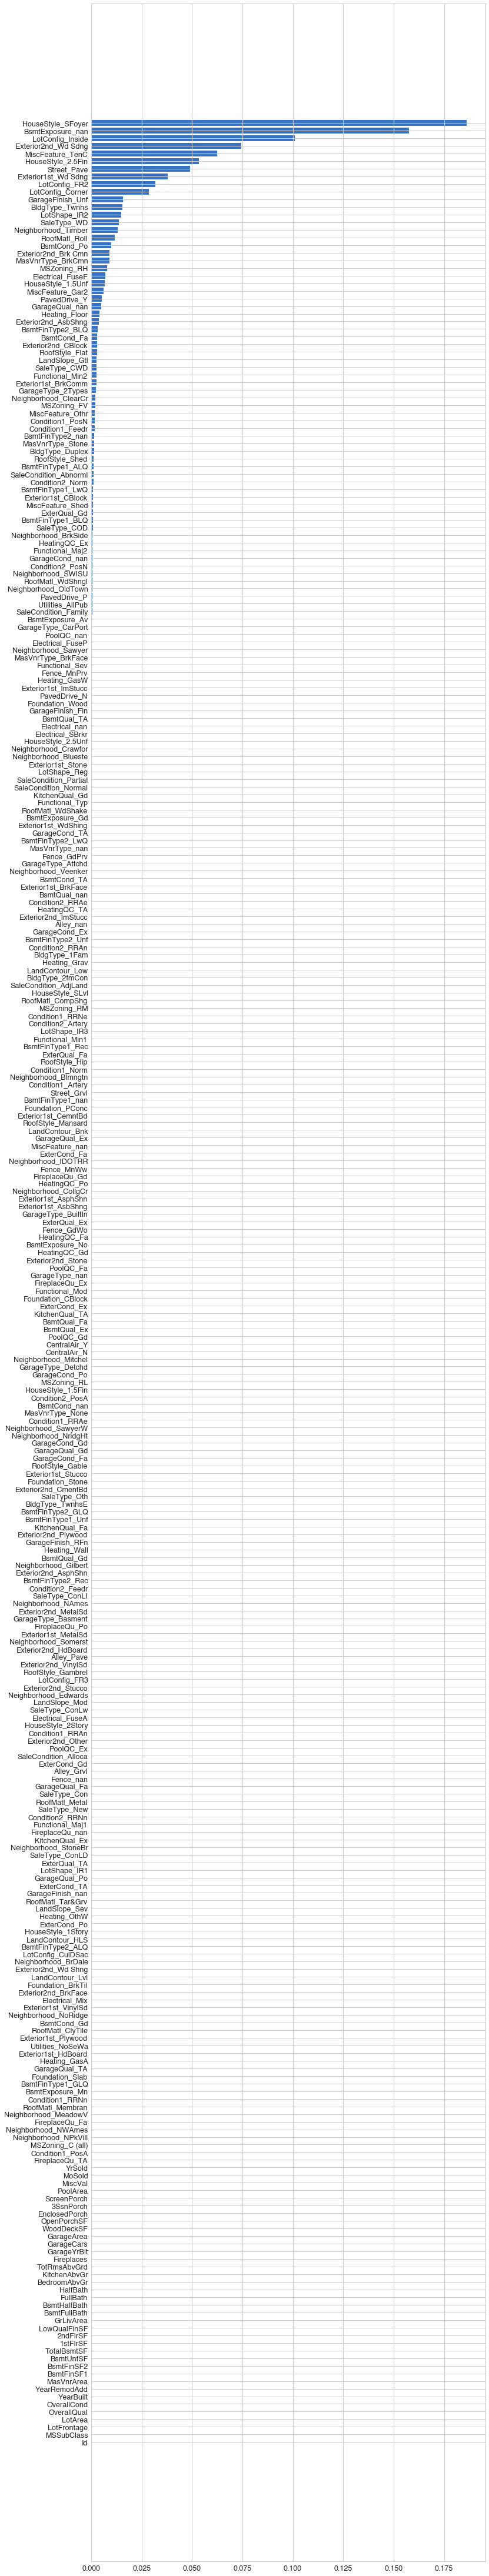

In [109]:
# важность признаков
plt.figure(figsize=(12,80))
plt.barh(np.arange(len(clf_rf.feature_importances_)), np.sort(clf_rf.feature_importances_))
plt.yticks(np.arange(len(X.columns)), X.columns)

In [113]:
data_all = pd.concat([X, y], axis=1)
data_all

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,LotConfig_FR2,Exterior1st_Wd Sdng,Street_Pave,HouseStyle_2.5Fin,MiscFeature_TenC,Exterior2nd_Wd Sdng,LotConfig_Inside,BsmtExposure_nan,HouseStyle_SFoyer,target
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,1,0,0,0,1,0,0,6
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,1,0,1,0,0,0,0,0,0,5
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,1,0,0,0,1,0,0,6
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,1,1,0,0,0,0,0,0,4
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,1,0,1,0,0,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,0,1,0,0,0,1,0,0,5
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,0,0,1,0,0,0,1,0,0,6
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,0,1,0,0,0,1,0,0,8
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,0,0,1,0,0,0,1,0,0,4


In [143]:
# Возьмем параметры, которые имеют наибольшую корреляцию с target
top_param = data_all.corr()[data_all.corr().target > 0.4].index

In [144]:
# Найдем наилучшую комбинацию параметров
norm_data = list(top_param[:-1])

import itertools

y = data['target']
dict_param = {}
maxim = 0
q = 0

for n in range(1, len(norm_data)):
    
    for i in itertools.combinations(norm_data, n):
        X = data999[list(i)]
        clf_tree = DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)
        reg = clf_tree.fit(X, y)
        q = reg.score(X, y)
        
        if q > maxim:
            dict_param[i] = q
            maxim = q
dict_param

{('OverallQual',): 0.4006849315068493,
 ('TotalBsmtSF',): 0.41506849315068495,
 ('GrLivArea',): 0.42054794520547945,
 ('OverallQual', 'YearBuilt'): 0.4726027397260274,
 ('OverallQual', 'TotalBsmtSF'): 0.5047945205479452,
 ('OverallQual', '1stFlrSF'): 0.5054794520547945,
 ('OverallQual', 'GrLivArea'): 0.5089041095890411,
 ('YearBuilt', 'GrLivArea'): 0.5191780821917809,
 ('OverallQual', 'YearBuilt', 'TotalBsmtSF'): 0.5267123287671233,
 ('OverallQual', 'YearBuilt', '1stFlrSF'): 0.5397260273972603,
 ('OverallQual', 'YearBuilt', 'GrLivArea'): 0.5513698630136986,
 ('YearBuilt', 'TotalBsmtSF', 'GrLivArea'): 0.5684931506849316,
 ('YearBuilt', '1stFlrSF', 'GrLivArea'): 0.5691780821917808,
 ('OverallQual', 'TotalBsmtSF', 'GrLivArea', 'GarageYrBlt'): 0.576027397260274,
 ('OverallQual', 'TotalBsmtSF', 'GrLivArea', 'GarageArea'): 0.5794520547945206,
 ('OverallQual',
  'TotalBsmtSF',
  'GrLivArea',
  'GarageYrBlt',
  'GarageArea'): 0.5883561643835616,
 ('OverallQual',
  'TotalBsmtSF',
  'GrLivArea',

In [145]:
best_param = ['YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', 'GrLivArea', 'Fireplaces', 'GarageYrBlt', 'BsmtFinType1_GLQ', 'KitchenQual_Ex']